# 1 可视化整个模型中的输入输出，方便分析

In [ ]:
#---------------------------------#
#  预备工作：
#  导入库
#  加载配置文件
#  加载模型，加载数据集
#---------------------------------#

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#---------------------------------#
#  load  configs and checkpoint 
#---------------------------------#
import torch
from configs.config import get_config
from models.graphModel import GraphModel
from utils.graphDataset import GraphDataset
cfg = get_config()



In [ ]:
cfg.JSON_PATH = r'configs\train_MOT17.json'
test_dataset = GraphDataset(cfg,'Validation',False)
# raw_tra_graph,raw_det_graph,gt_matrix = test_dataset.__getitem__(2100)

In [ ]:
# k=13
# cfg.BT_DIRECTED = True
# cfg.K_NEIGHBOR  = k
# cfg.BT_SELF_LOOP= False
model = GraphModel(cfg.MODEL_YAML_PATH)
checkpoint = torch.load(r'model_weights\DA_120epoch.pth',map_location='cpu')
model.load_state_dict(checkpoint["model"], strict=False)

In [4]:
model.edgeEncoder.bt_self_loop = False

In [ ]:
model.edgeEncoder.bt_self_loop,model.edgeEncoder.bt_cosine

In [ ]:
from tqdm import tqdm
for i in tqdm(range(0,len(test_dataset))):
    raw_tra_graph,raw_det_graph,gt_matrix = test_dataset.__getitem__(i)
    # print(raw_tra_graph.num_nodes)
    if raw_det_graph.num_nodes == 1 or raw_tra_graph.num_nodes == 1:
        print(i)
        break
raw_tra_graph,raw_det_graph

In [ ]:

import sys
def get_size_KB(obj, seen=None):
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size_KB(v, seen) for v in obj.values()])
        size += sum([get_size_KB(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size_KB(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size_KB(i, seen) for i in obj])
    return size /1024

get_size_KB(test_dataset.dets_dict)

## 1.1 轨迹图与检测图节点 原始像素可视化

In [ ]:
import math
from matplotlib import pyplot as plt
def scale_patch_to_0_1(patch):
    """将裁剪后的图像patch缩放到[0, 1]范围内"""
    patch_max = torch.max(patch)
    patch_min = torch.min(patch)
    patch = (patch - patch_min) / (patch_max - patch_min)  # 确保像素值在 [0, 1] 范围
    return patch 
# import torchvision.transforms.functional as F
tra_obj_ims = raw_tra_graph.x
num_tra    = tra_obj_ims.shape[0] 
num_rows = math.ceil(num_tra )
fig, axs   = plt.subplots(num_rows, 4, figsize=(50, 20))
# # plt.imshow(tra_obj_im)

for i in range(num_tra):
    row = i //4
    col = i % 4
    patch = scale_patch_to_0_1(tra_obj_ims[i])
    # print(patch.shape)
    axs[row,col].imshow(patch.permute(1,2,0).numpy())
    axs[row,col].axis('off')
plt.show()

In [ ]:
det_obj_ims = raw_det_graph.x
num_tra    = det_obj_ims.shape[0] 
num_rows = math.ceil(num_tra / 4)
fig, axs   = plt.subplots(num_rows, 4, figsize=(50, 20))
# # plt.imshow(tra_obj_im)

for i in range(num_tra):
    row = i //4
    col = i % 4
    patch = scale_patch_to_0_1(det_obj_ims[i])
    axs[row,col].imshow(patch.permute(1,2,0).numpy())
    axs[row,col].axis('off')
plt.show()

## 1.2 轨迹图与检测图经过Node Encoder之后的热力图

In [ ]:
tra_graph = model.nodeEncoder(raw_tra_graph.clone())
det_graph = model.nodeEncoder(raw_det_graph.clone())

import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F 

#---------------------------------#
#  轨迹图
#---------------------------------#


node_embed = tra_graph.x
cos_sim_matrix = F.cosine_similarity(node_embed.unsqueeze(0), node_embed.unsqueeze(1), dim=2)
plt.figure(figsize=(8, 6))  # 设置热图大小
# sns.heatmap(cos_sim_matrix.detach().numpy(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
sns.heatmap(cos_sim_matrix.detach().numpy(), cmap='coolwarm', cbar=True)

# 添加标题
plt.title("Cosine Similarity Matrix of Trajectory Nodes")

# 显示图像
plt.show()

In [ ]:
node_embed = det_graph.x
cos_sim_matrix = F.cosine_similarity(node_embed.unsqueeze(0), node_embed.unsqueeze(1), dim=2)
plt.figure(figsize=(8, 6))  # 设置热图大小
# sns.heatmap(cos_sim_matrix.detach().numpy(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
sns.heatmap(cos_sim_matrix.detach().numpy(), cmap='coolwarm', cbar=True)

# 添加标题
plt.title("Cosine Similarity Matrix of detection Nodes")

# 显示图像
plt.show()

## 1.3 经过EdgeEncoder  完成图的构建之后，可视化图

In [ ]:
tra_graph,tra_graph.edge_index,tra_graph.location_info[:,-2:]

In [9]:
tra_graph = model.edgeEncoder(tra_graph,model.k)
det_graph = model.edgeEncoder(det_graph,model.k)

In [ ]:
#---------------------------------#
#  带有边颜色的画图  不同K
#---------------------------------#
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

# Convert your graph to NetworkX and prepare positions
pos_dict = {}
for idx, pos in enumerate(tra_graph.location_info[:, :2]):
    pos_dict[idx] = pos.numpy()

G_tra = to_networkx(tra_graph, to_undirected=False)

# Plot the graph
plt.figure(figsize=(5, 3))

# Draw nodes with better visualization parameters
nx.draw_networkx_nodes(
    G_tra,
    pos=pos_dict,
    node_size=200,  # Increase node size
    # node_color='w',  # Set node color
)

# Draw edges with better visualization parameters
edge_colors = ['m' if edge[1] == 0 else 'grey' for edge in G_tra.edges]
nx.draw_networkx_edges(
    G_tra,
    pos=pos_dict,
    width=1,  # Make edges thicker
    edge_color=edge_colors,
    arrows=True,  # Enable arrows
    arrowsize=10,  # Increase arrow size
    arrowstyle='-|>',  # Use a solid arrow style
)

# Draw labels with better visualization parameters
nx.draw_networkx_labels(
    G_tra,
    pos=pos_dict,
    font_size=10,  # Set font size for labels
    # font_color='darkblue',  # Set font color for labels
)

plt.title(f'tra-graph (K: {model.k})', fontsize=16)
plt.show()


In [ ]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

# Convert your graph to NetworkX and prepare positions
pos_dict = {}
for idx, pos in enumerate(tra_graph.location_info[:, :2]):
    pos_dict[idx] = pos.numpy()

G_tra = to_networkx(tra_graph, to_undirected=False)

# Plot the graph
plt.figure(figsize=(10, 6))

# Draw nodes and edges with better visualization parameters
nx.draw(
    G_tra,
    pos=pos_dict,
    with_labels=True,
    node_size=200,  # Increase node size
    # node_color='blue',  # Set node color
    # edge_color='gray',  # Set edge color
    width=1,  # Make edges thicker
    font_size=10,  # Set font size for labels
    font_color='darkblue',  # Set font color for labels
    arrows=True,  # Enable arrows
    arrowsize=10,  # Increase arrow size
    arrowstyle='-|>',  # Use a solid arrow style
)

plt.title(f'tra-graph (nodes:{tra_graph.num_nodes})', fontsize=16)
plt.show()


In [ ]:
pos_dict = {}
for idx , pos in enumerate(det_graph.location_info[:,:2]):
    pos_dict[idx] = pos.numpy()

G_det = to_networkx(det_graph, to_undirected=False)
plt.figure(figsize=(5, 3))
nx.draw(
    G_det,
    pos=pos_dict,
    with_labels=True,
    node_size=300,  # Increase node size
    # node_color='blue',  # Set node color
    # edge_color='gray',  # Set edge color
    width=1,  # Make edges thicker
    font_size=10,  # Set font size for labels
    font_color='darkblue',  # Set font color for labels
    arrows=True,  # Enable arrows
    arrowsize=10,  # Increase arrow size
    arrowstyle='-|>',  # Use a solid arrow style
)

# nx.draw(G_det,with_labels=True,pos=pos_dict)
plt.title(f'det-graph(Nodes:{det_graph.num_nodes})')
plt.show()

In [ ]:
det_graph,tra_graph

## 1.4  真值矩阵可视化

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F 

plt.figure(figsize=(8, 6))  # 设置热图大小
# sns.heatmap(cos_sim_matrix.detach().numpy(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
sns.heatmap(gt_matrix, annot=False, cmap='Blues', cbar=False, linewidths=0.5, square=True)

# 添加标题
plt.title("groundtruth matrix")

# 显示图像
plt.show()

## 1.5 graphconv可视化

In [13]:
#---------------------------------#
#  tra-graph first
#---------------------------------#
node_embedding = tra_graph.x
edge_embedding = tra_graph.edge_attr
edge_index     = tra_graph.edge_index

node_embedding_sg1 = model.graphconvLayer.sg1Func(node_embedding,edge_index,edge_embedding)      # torch.Size([32, 32])
node_embedding_sg2 = model.graphconvLayer.sg2Func(node_embedding_sg1,edge_index,edge_embedding)  # torch.Size([32, 64])
node_embedding_sg3 = model.graphconvLayer.sg3Func(node_embedding_sg2,edge_index,edge_embedding)  # torch.Size([32, 96])


node_embedding_dg1 = model.graphconvLayer.dg1Func(node_embedding_sg1,cfg.K_NEIGHBOR)  # torch.Size([32,64])
node_embedding_dg2 = model.graphconvLayer.dg2Func(node_embedding_dg1,cfg.K_NEIGHBOR)  # torch.Size([32, 96])


node_embedding_cat1  = torch.cat([node_embedding_sg1,node_embedding_dg1,node_embedding_dg2,
                                    node_embedding_sg2,node_embedding_sg3],dim=1)     # torch.Size([32, 352])
node_embedding_fuse1 = model.graphconvLayer.fuse1Func(node_embedding_cat1)  # torch.Size([32, 1024])
node_embedding_cat2  = torch.cat([node_embedding_fuse1,node_embedding_cat1],dim=1)  # torch.Size([32, 1376])
node_embedding_output_tra= model.graphconvLayer.fuse2Func(node_embedding_cat2)  # torch.Size([32, 128])

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假设 node_embedding_output 是你的嵌入向量
embeddings = node_embedding_output_tra.cpu().detach().numpy()

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=0,perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)
plt.title('tra-graph after grapnconv')
# 绘制嵌入向量
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()


In [15]:
#---------------------------------#
#  det-graph first
#---------------------------------#
node_embedding = det_graph.x
edge_embedding = det_graph.edge_attr
edge_index     = det_graph.edge_index

node_embedding_sg1 = model.graphconvLayer.sg1Func(node_embedding,edge_index,edge_embedding)      # torch.Size([32, 32])
node_embedding_sg2 = model.graphconvLayer.sg2Func(node_embedding_sg1,edge_index,edge_embedding)  # torch.Size([32, 64])
node_embedding_sg3 = model.graphconvLayer.sg3Func(node_embedding_sg2,edge_index,edge_embedding)  # torch.Size([32, 96])


node_embedding_dg1 = model.graphconvLayer.dg1Func(node_embedding_sg1,cfg.K_NEIGHBOR)  # torch.Size([32,64])
node_embedding_dg2 = model.graphconvLayer.dg2Func(node_embedding_dg1,cfg.K_NEIGHBOR)  # torch.Size([32, 96])


node_embedding_cat1  = torch.cat([node_embedding_sg1,node_embedding_dg1,node_embedding_dg2,
                                    node_embedding_sg2,node_embedding_sg3],dim=1)     # torch.Size([32, 352])
node_embedding_fuse1 = model.graphconvLayer.fuse1Func(node_embedding_cat1)  # torch.Size([32, 1024])
node_embedding_cat2  = torch.cat([node_embedding_fuse1,node_embedding_cat1],dim=1)  # torch.Size([32, 1376])
node_embedding_output_det= model.graphconvLayer.fuse2Func(node_embedding_cat2)  # torch.Size([32, 128])

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假设 node_embedding_output 是你的嵌入向量
embeddings = node_embedding_output_det.cpu().detach().numpy()

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=0,perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)
plt.title('det-graph after grapnconv')
# 绘制嵌入向量
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()


## 1.6 匹配矩阵可视化

In [37]:
corr = torch.mm(node_embedding_output_tra,node_embedding_output_det.transpose(1,0))
n1   = torch.norm(node_embedding_output_tra,dim=-1,keepdim=True)
n2   = torch.norm(node_embedding_output_det,dim=-1,keepdim=True)
cost = - corr / torch.mm(n1,n2.transpose(1,0))  

# 2. Prepare the augmented cost matrix for Sinkhorn
m , n = cost.shape
bins0 = model.alpha.expand(m, 1)
bins1 = model.alpha.expand(1, n)
alpha = model.alpha.expand(1, 1)
couplings = torch.cat([torch.cat([cost,bins0],dim=-1),
                        torch.cat([bins1,alpha],dim=-1)],dim=0)
# # norm  = 1 / (m+n)  
a_aug = torch.full((m+1,),1,dtype=torch.float32) 
b_aug = torch.full((n+1,),1,dtype=torch.float32) 
# a = torch.full((m,),0.95,dtype=torch.float32) 
# b = torch.full((n,),0.95,dtype=torch.float32) 
# a_aug[-1] = 0.95
# b_aug[-1] = 0.95

# pred_mtx = self.sinkhornLayer(couplings,a_aug,b_aug,
#                             self.sinkhorn_iters,torch.exp(self.eplison) + 0.03)


# to original possibility space 
pred_mtx = model.sinkhornLayer(couplings,a_aug,b_aug,
                            #   lambd_sink = torch.exp(self.eplison) + 0.03) * (m + n)
                                lambd_sink = torch.exp(model.eplison) + 0.03)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # 设置热图大小
sns.heatmap(pred_mtx[:,:].detach().numpy(), cmap='coolwarm', cbar=True)

# 添加标题
plt.title("affinity matrix")

# torch.sum(pred_mtx, dim=1),torch.sum(pred_mtx, dim=0),

In [ ]:
from models.graphToolkit import hungarian

match_mtx,match_idx,unmatch_tra,unmatch_det = hungarian(pred_mtx.detach(),0.5)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # 设置热图大小
sns.heatmap(match_mtx[:-1,:-1], cmap='coolwarm', cbar=True)

# 添加标题
plt.title("assignment matrix")

# torch.sum(pred_mtx, dim=1),torch.sum(pred_mtx, dim=0),

In [ ]:
import numpy as np 
TP = np.sum(np.logical_and(match_mtx == 1, gt_matrix.numpy() == 1))
FP = np.sum(np.logical_and(match_mtx == 1, gt_matrix.numpy() == 0))
FN = np.sum(np.logical_and(match_mtx == 0, gt_matrix.numpy() == 1))

# Precision
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Recall
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# F1 Score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
f1_score

# 2. 假如用这个网络来分辨出跟踪的同一个目标，进行可视化

In [ ]:

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#---------------------------------#
#  load  configs and checkpoint 
#---------------------------------#
import torch
from configs.config import get_config
from models.graphModel import GraphModel
from utils.graphDataset import GraphDataset
cfg = get_config()
model = GraphModel(cfg)
# test_dataset = GraphDataset(cfg,'Train',True)
# checkpoint = torch.load(r'experiments\checkpoints\latest.pth')
checkpoint = torch.load(r'experiments\checkpoints\bestScore(1.0)_epoch(86).pth')
model.load_state_dict(checkpoint["model"], strict=False)

# 3. 统计 在不同帧率下，同一目标移动的像素均值（包括 移动视角与静止视角）

In [ ]:
#---------------------------------#
#  data - whole dataset [MOT17,MOT20,DanceTrack]
#---------------------------------#

import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
def calculate_average_movement(df, lifespan):
    results = []

    for id_, group in df.groupby('id'):
        # 获取当前目标的中心点坐标
        centers = group[['frame', 'center_x', 'center_y']].reset_index(drop=True)
        # n_frames = len(centers)

        # # 计算每个lifespan范围内的均值
        # for start_frame in range(1, n_frames - lifespan + 1):
        #     end_frame = start_frame + lifespan - 1
        #     sub_group = centers[(centers['frame'] >= start_frame) & (centers['frame'] <= end_frame)]

        #     # 计算x, y坐标的平均移动距离
        #     start_center = sub_group[sub_group['frame'] == start_frame][['center_x', 'center_y']].values[0]
        #     end_center = sub_group[sub_group['frame'] == end_frame][['center_x', 'center_y']].values[0]
        #     euclidean_distance = np.linalg.norm(start_center - end_center)
        #     # avg_displacement = displacements.mean() if len(displacements) > 0 else 0
        max_frame = int(centers['frame'].max())
        min_frame = int(centers['frame'].min())
        for start_frame in range(min_frame,max_frame - lifespan + 1):
            end_frame = start_frame + lifespan 

            start_x = float(centers[(centers['frame'] == start_frame)]['center_x'].iloc[0])
            start_y = float(centers[(centers['frame'] == start_frame)]['center_y'].iloc[0])
            end_x   = float(centers[(centers['frame'] == end_frame)]['center_x'].iloc[0])
            end_y   = float(centers[(centers['frame'] == end_frame)]['center_y'].iloc[0])
            euclidean_distance = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
            results.append({'id': id_, 'frame_range': f'{start_frame}-{end_frame}', 'avg_displacement': euclidean_distance})
    return pd.DataFrame(results)

lifespan_total = 30
dataset_type = {
    'MOT17': ['train'],
    # 'MOT20': ['train'],
    # 'DanceTrack': ['train','val']
}
all_life_span_res = []
# output_file = os.path.join(,'avgMovement.xlsx')
for lifespan in range(2,lifespan_total + 1):
    output_folder = os.path.join('experiments','statisticalData','avgMovement',f'windowSize[{lifespan}]')
    os.makedirs(output_folder,exist_ok=True)
    output_result = {}
    maxvalue_list = []
    meanvalue_seq = []
    maxvalue_seq  = []

    for dataset in dataset_type.keys():
        for sub_folder in dataset_type[dataset]:
            sub_folder_path = os.path.join('datasets',dataset,sub_folder)
            meanvalue_seq = []
            for seq in os.listdir(sub_folder_path):
                if not os.path.isdir(os.path.join(sub_folder_path,seq)):
                    continue
                gt_path   = os.path.join(sub_folder_path,seq,'gt','gt.txt')
                info_path = os.path.join(sub_folder_path,seq,'seqinfo.ini')
                with open(info_path,'r') as f:
                    lines_split = [ l.split('=') for l in f.read().splitlines()[1:]]
                    info_dict  = dict(s for s in lines_split if isinstance(s,list) and len(s) == 2)
                print(f"seq[{seq}] info: framerate[{info_dict['frameRate']}], height[{info_dict['imHeight']}], width[{info_dict['imWidth']}]")
                data = np.loadtxt(gt_path,delimiter=',')
                df = pd.DataFrame(data, columns=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'ignore1', 'obj_type', 'ignore3'])
                df = df[df['obj_type'].isin([1,2,7])]
                df['center_x'] = df['bb_left'] + df['bb_width']  / 2
                df['center_y'] = df['bb_top']  + df['bb_height'] / 2
                df = df.sort_values(by=['id', 'frame'])

                result = calculate_average_movement(df, lifespan)

                # output_result[seq] = result[result['avg_displacement'] != 0]
                meanvalue = result[result['avg_displacement'] != 0].groupby('id')['avg_displacement'].mean().mean()
                maxvalue  = result[result['avg_displacement'] != 0].groupby('id')['avg_displacement'].mean().max()
                meanvalue_seq.append(meanvalue)
                maxvalue_seq.append(maxvalue)


                # maxvalue_list.append(maxvalue)
                # print(f"seq[{seq}] mean movement:[{meanvalue:.4f}], max movement:[{maxvalue:.4f}] ")
        #         break
        #     break
        # break
            # 绘制当前序列的最大移动距离柱状图
            plt.figure(figsize=(10, 6))
            mean_value = np.mean(maxvalue_seq)
            plt.bar(range(len(maxvalue_seq)), maxvalue_seq, color='blue',label='Mean Movement')
            for i, v in enumerate(maxvalue_seq):
                plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
            plt.axhline(y=mean_value, color='r', linestyle='--',label=f'mean:{mean_value:.2f}') 
            # plt.text(len(meanvalue_seq) - 1, mean_value, f'Mean: {mean_value:.2f}', ha='right', va='bottom')  # 标注均值
            plt.xlabel('Sequence')
            plt.legend()
            plt.ylabel('Max Movement')
            plt.title(f'Max Movement for Sequence {dataset}({sub_folder}) || WindowSize {lifespan}')
            plt.xticks(range(len(maxvalue_seq)), [f'Seq {i}' for i in range(1, len(maxvalue_seq) + 1)])
            plt.savefig(os.path.join(output_folder,f'maxMovement_{dataset}({sub_folder})-Window_{lifespan}.png'))
            plt.close()
            dataset_stats_df = pd.DataFrame({
                'lifespan': [lifespan] * len(meanvalue_seq),
                'seq':range(1,len(meanvalue_seq)+1) ,
                'max/seq': meanvalue_seq,
                'mean': mean_value,
            })
            all_life_span_res.append(dataset_stats_df)
final_res_df = pd.concat(
    all_life_span_res, ignore_index=True
)
final_res_df.to_csv(f'experiments/statisticalData/avgMovement/MOT17[2-{lifespan_total}].csv', index=False)

seq[MOT17-02] info: framerate[30], height[1080], width[1920]
seq[MOT17-04] info: framerate[30], height[1080], width[1920]
seq[MOT17-05] info: framerate[14], height[480], width[640]
seq[MOT17-09] info: framerate[30], height[1080], width[1920]
seq[MOT17-10] info: framerate[30], height[1080], width[1920]
seq[MOT17-11] info: framerate[30], height[1080], width[1920]
seq[MOT17-13] info: framerate[25], height[1080], width[1920]
seq[MOT17-02] info: framerate[30], height[1080], width[1920]
seq[MOT17-04] info: framerate[30], height[1080], width[1920]
seq[MOT17-05] info: framerate[14], height[480], width[640]
seq[MOT17-09] info: framerate[30], height[1080], width[1920]
seq[MOT17-10] info: framerate[30], height[1080], width[1920]
seq[MOT17-11] info: framerate[30], height[1080], width[1920]
seq[MOT17-13] info: framerate[25], height[1080], width[1920]
seq[MOT17-02] info: framerate[30], height[1080], width[1920]
seq[MOT17-04] info: framerate[30], height[1080], width[1920]
seq[MOT17-05] info: framerat

In [ ]:

import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import concurrent.futures

def calculate_average_movement(df, lifespan):
    results = []

    for id_, group in df.groupby('id'):
        # 获取当前目标的中心点坐标
        centers = group[['frame', 'center_x', 'center_y']].reset_index(drop=True)
        # n_frames = len(centers)

        # # 计算每个lifespan范围内的均值
        # for start_frame in range(1, n_frames - lifespan + 1):
        #     end_frame = start_frame + lifespan - 1
        #     sub_group = centers[(centers['frame'] >= start_frame) & (centers['frame'] <= end_frame)]

        #     # 计算x, y坐标的平均移动距离
        #     start_center = sub_group[sub_group['frame'] == start_frame][['center_x', 'center_y']].values[0]
        #     end_center = sub_group[sub_group['frame'] == end_frame][['center_x', 'center_y']].values[0]
        #     euclidean_distance = np.linalg.norm(start_center - end_center)
        #     # avg_displacement = displacements.mean() if len(displacements) > 0 else 0
        max_frame = int(centers['frame'].max())
        min_frame = int(centers['frame'].min())
        for start_frame in range(min_frame,max_frame - lifespan + 1):
            end_frame = start_frame + lifespan 

            start_x = float(centers[(centers['frame'] == start_frame)]['center_x'].iloc[0])
            start_y = float(centers[(centers['frame'] == start_frame)]['center_y'].iloc[0])
            end_x   = float(centers[(centers['frame'] == end_frame)]['center_x'].iloc[0])
            end_y   = float(centers[(centers['frame'] == end_frame)]['center_y'].iloc[0])
            euclidean_distance = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
            results.append({'id': id_, 'frame_range': f'{start_frame}-{end_frame}', 'avg_displacement': euclidean_distance})
    return pd.DataFrame(results)

def process_sequence(seq, sub_folder, lifespan):
    gt_path   = os.path.join(sub_folder,seq,'gt','gt.txt')
    info_path = os.path.join(sub_folder,seq,'seqinfo.ini')
    with open(info_path,'r') as f:
        lines_split = [ l.split('=') for l in f.read().splitlines()[1:]]
        info_dict  = dict(s for s in lines_split if isinstance(s,list) and len(s) == 2)
    print(f"seq[{seq}] info: framerate[{info_dict['frameRate']}], height[{info_dict['imHeight']}], width[{info_dict['imWidth']}]")
    data = np.loadtxt(gt_path,delimiter=',')
    df = pd.DataFrame(data, columns=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'ignore1', 'obj_type', 'ignore3'])
    df = df[df['obj_type'].isin([1,2,7])]
    df['center_x'] = df['bb_left'] + df['bb_width']  / 2
    df['center_y'] = df['bb_top']  + df['bb_height'] / 2
    df = df.sort_values(by=['id', 'frame'])


    result = calculate_average_movement(df, lifespan)
    meanvalue = result[result['avg_displacement'] != 0].groupby('id')['avg_displacement'].mean().mean()
    return (seq,meanvalue)

def main():
    lifespan_total = 30
    dataset_type = {
        'MOT17': ['train'],
        # 'MOT20': ['train'],
        # 'DanceTrack': ['train','val']
    }
    all_life_span_res = []

    for lifespan in range(2, lifespan_total + 1):
        output_folder = os.path.join('experiments', 'statisticalData', 'avgMovement', f'windowSize[{lifespan}]')
        os.makedirs(output_folder, exist_ok=True)
        output_result = {}
        maxvalue_list = []
        meanvalue_seq = []

        for dataset in dataset_type.keys():
            for sub_folder in dataset_type[dataset]:
                sub_folder_path = os.path.join('datasets', dataset, sub_folder)
                meanvalue_seq = []

                with concurrent.futures.ThreadPoolExecutor() as executor:
                    futures = []
                    for seq in os.listdir(sub_folder_path):
                        if not os.path.isdir(os.path.join(sub_folder_path, seq)):
                            continue
                        futures.append(executor.submit(process_sequence, seq, sub_folder_path, lifespan))

                    for future in concurrent.futures.as_completed(futures):
                        meanvalue_seq.append(future.result())

                # 绘制当前序列的最大移动距离柱状图
                plt.figure(figsize=(10, 6))
                mean_value = np.mean(meanvalue_seq)
                plt.bar(range(len(meanvalue_seq)), meanvalue_seq, color='blue', label='Mean Movement')
                for i, v in enumerate(meanvalue_seq):
                    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
                plt.axhline(y=mean_value, color='r', linestyle='--', label=f'mean:{mean_value:.2f}')
                plt.xlabel('Sequence')
                plt.legend()
                plt.ylabel('Mean Movement')
                plt.title(f'Mean Movement for Sequence {dataset}({sub_folder}) || WindowSize {lifespan}')
                plt.xticks(range(len(meanvalue_seq)), [f'Seq {i}' for i in range(1, len(meanvalue_seq) + 1)])
                plt.savefig(os.path.join(output_folder, f'meanMovement_{dataset}({sub_folder})-Window_{lifespan}.png'))
                plt.close()

                dataset_stats_df = pd.DataFrame({
                    'lifespan': [lifespan] * len(meanvalue_seq),
                    'seq': range(len(meanvalue_seq)),
                    'max/seq': meanvalue_seq,
                    'mean': mean_value,
                })
                all_life_span_res.append(dataset_stats_df)

    final_res_df = pd.concat(
        all_life_span_res, ignore_index=True
    )
    final_res_df.to_csv(f'experiments/statisticalData/avgMovement/MOT17[2-{lifespan_total}].csv', index=False)

if __name__ == "__main__":
    main()

seq[MOT17-02] info: framerate[30], height[1080], width[1920]
seq[MOT17-04] info: framerate[30], height[1080], width[1920]
seq[MOT17-05] info: framerate[14], height[480], width[640]
seq[MOT17-09] info: framerate[30], height[1080], width[1920]
seq[MOT17-10] info: framerate[30], height[1080], width[1920]
seq[MOT17-11] info: framerate[30], height[1080], width[1920]
seq[MOT17-13] info: framerate[25], height[1080], width[1920]
seq[MOT17-02] info: framerate[30], height[1080], width[1920]
seq[MOT17-04] info: framerate[30], height[1080], width[1920]
seq[MOT17-05] info: framerate[14], height[480], width[640]
seq[MOT17-09] info: framerate[30], height[1080], width[1920]
seq[MOT17-10] info: framerate[30], height[1080], width[1920]
seq[MOT17-11] info: framerate[30], height[1080], width[1920]
seq[MOT17-13] info: framerate[25], height[1080], width[1920]


Text(0.5, 1.0, 'Mean Movement for Sequence MOT17(train) || WindowSize 2')

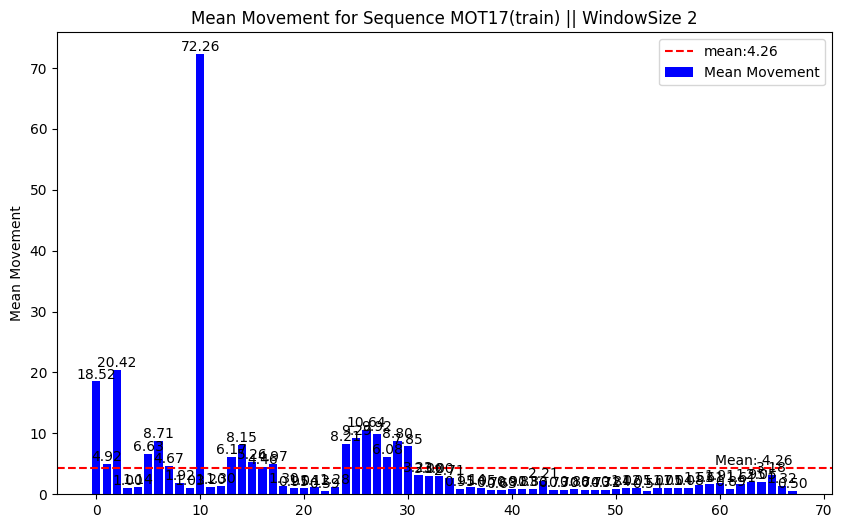

In [33]:
meanv = list(result[result['avg_displacement'] != 0].groupby('id')['avg_displacement'].mean())
ids  = list(map(int,result[result['avg_displacement'] != 0]['id'].unique()))
plt.figure(figsize=(10, 6))
meanv_2 = np.mean(meanv)
plt.bar(range(len(meanv)), meanv, color='blue',label='Mean Movement')
for i, v in enumerate(meanv):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
plt.axhline(y=meanv_2, color='r', linestyle='--',label=f'mean:{meanv_2:.2f}') 
plt.text(len(meanv) - 1, meanv_2, f'Mean: {meanv_2:.2f}', ha='right', va='bottom')  # 标注均值
# plt.xlabel('Sequence')
plt.legend()
plt.ylabel('Mean Movement')
plt.title(f'Mean Movement for Sequence {dataset}({sub_folder}) || WindowSize {lifespan}')
# plt.xticks(range(len(meanvalue_seq)), [f'Seq {i}' for i in range(1, len(meanvalue_seq) + 1)])
# plt.savefig(os.path.join(output_folder,f'meanMovement_{dataset}({sub_folder})-Window_{lifespan}.png'))
# plt.close()

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

lifespan_total = 30
dataset_type = {
    'MOT17': ['train'],
    # 'MOT20': ['train'],
    # 'DanceTrack': ['train','val']
}

all_life_span_res = []
for lifespan in range(2, lifespan_total + 1):
    output_result = {}
    maxvalue_list = []
    meanvalue_seq = []

    def calculate_average_movement(df, lifespan):
        results = []

        for id_, group in df.groupby('id'):
            # 获取当前目标的中心点坐标
            centers = group[['frame', 'center_x', 'center_y']].reset_index(drop=True)
            # n_frames = len(centers)

            # # 计算每个lifespan范围内的均值
            # for start_frame in range(1, n_frames - lifespan + 1):
            #     end_frame = start_frame + lifespan - 1
            #     sub_group = centers[(centers['frame'] >= start_frame) & (centers['frame'] <= end_frame)]

            #     # 计算x, y坐标的平均移动距离
            #     start_center = sub_group[sub_group['frame'] == start_frame][['center_x', 'center_y']].values[0]
            #     end_center = sub_group[sub_group['frame'] == end_frame][['center_x', 'center_y']].values[0]
            #     euclidean_distance = np.linalg.norm(start_center - end_center)
            #     # avg_displacement = displacements.mean() if len(displacements) > 0 else 0
            max_frame = int(centers['frame'].max())
            min_frame = int(centers['frame'].min())
            for start_frame in range(min_frame,max_frame - lifespan + 1):
                end_frame = start_frame + lifespan 

                start_x = float(centers[(centers['frame'] == start_frame)]['center_x'].iloc[0])
                start_y = float(centers[(centers['frame'] == start_frame)]['center_y'].iloc[0])
                end_x   = float(centers[(centers['frame'] == end_frame)]['center_x'].iloc[0])
                end_y   = float(centers[(centers['frame'] == end_frame)]['center_y'].iloc[0])
                euclidean_distance = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
                results.append({'id': id_, 'frame_range': f'{start_frame}-{end_frame}', 'avg_displacement': euclidean_distance})
        return pd.DataFrame(results)

    def process_sequence(seq, sub_folder_path, lifespan):
        gt_path = os.path.join(sub_folder_path, seq, 'gt', 'gt.txt')
        info_path = os.path.join(sub_folder_path, seq, 'seqinfo.ini')
        with open(info_path, 'r') as f:
            lines_split = [l.split('=') for l in f.read().splitlines()[1:]]
            info_dict = dict(s for s in lines_split if isinstance(s, list) and len(s) == 2)
        data = np.loadtxt(gt_path, delimiter=',')
        df = pd.DataFrame(data, columns=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'ignore1', 'obj_type', 'ignore3'])
        df = df[df['obj_type'].isin([1, 2, 7])]
        df['center_x'] = df['bb_left'] + df['bb_width'] / 2
        df['center_y'] = df['bb_top'] + df['bb_height'] / 2
        df = df.sort_values(by=['id', 'frame'])

        result = calculate_average_movement(df, lifespan)
        output_result[seq] = result[result['avg_displacement'] != 0]
        meanvalue = result[result['avg_displacement'] != 0].groupby('id')['avg_displacement'].mean().mean()
        maxvalue = result[result['avg_displacement'] != 0].groupby('id')['avg_displacement'].max().max()
        meanvalue_seq.append(maxvalue)
        maxvalue_list.append(maxvalue)

    for dataset in dataset_type.keys():
        for sub_folder in dataset_type[dataset]:
            sub_folder_path = os.path.join('datasets', dataset, sub_folder)
            with ThreadPoolExecutor() as executor:
                for seq in os.listdir(sub_folder_path):
                    if not os.path.isdir(os.path.join(sub_folder_path, seq)):
                        continue
                    executor.submit(process_sequence, seq, sub_folder_path, lifespan)

    dataset_stats_df = pd.DataFrame({
        'lifespan': [lifespan] * len(maxvalue_list),
        'seq':range(len(maxvalue_list)),
        'max/seq': maxvalue_list,
        'mean': np.mean(maxvalue_list),
    })
    all_life_span_res.append(dataset_stats_df)

final_res_df = pd.concat(
    all_life_span_res, ignore_index=True
)
final_res_df.to_csv('experiments/statisticalData/avgMovement/MOT17[2-30].csv', index=False)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lifespan remains defined but is not used in the updated context
lifespan = 9
dataset_type = {
    'MOT17': ['train'],
    'MOT20': ['train'],
    'DanceTrack': ['train', 'val']
}

output_folder = os.path.join('experiments', 'statisticalData', 'targetCounts')
os.makedirs(output_folder, exist_ok=True)
output_result = {}

def calculate_frame_target_counts(df):
    # Group by frame and count the number of unique IDs (targets) in each frame
    frame_counts = df.groupby('frame')['id'].nunique()
    return frame_counts

# Initialize lists to store overall statistics for all datasets
all_mean_values = []
all_max_values = []
all_min_values = []

for dataset in dataset_type.keys():
    dataset_mean_values = []
    dataset_max_values = []
    dataset_min_values = []

    for sub_folder in dataset_type[dataset]:
        sub_folder_path = os.path.join('datasets', dataset, sub_folder)
        seq_stats = []

        for seq in os.listdir(sub_folder_path):
            if not os.path.isdir(os.path.join(sub_folder_path, seq)):
                continue

            gt_path = os.path.join(sub_folder_path, seq, 'gt', 'gt.txt')
            info_path = os.path.join(sub_folder_path, seq, 'seqinfo.ini')

            with open(info_path, 'r') as f:
                lines_split = [l.split('=') for l in f.read().splitlines()[1:]]
                info_dict = dict(s for s in lines_split if isinstance(s, list) and len(s) == 2)

            # print(f"seq[{seq}] info: framerate[{info_dict['frameRate']}], height[{info_dict['imHeight']}], width[{info_dict['imWidth']}]")
            data = np.loadtxt(gt_path, delimiter=',')
            df = pd.DataFrame(data, columns=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'ignore1', 'obj_type', 'ignore3'])
            df = df[df['obj_type'].isin([1, 2, 7])]
            df = df.sort_values(by=['id', 'frame'])

            # Calculate frame target counts
            frame_counts = calculate_frame_target_counts(df)

            # Compute statistics for the current sequence
            meanv_2 = frame_counts.mean()
            max_value = frame_counts.max()
            min_value = frame_counts.min()

            dataset_mean_values.append(meanv_2)
            dataset_max_values.append(max_value)
            dataset_min_values.append(min_value)

            seq_stats.append({'seq': seq, 'mean': meanv_2, 'max': max_value, 'min': min_value})

            # print(f"seq[{seq}] mean targets per frame: [{mean_value:.4f}], max targets: [{max_value:.4f}], min targets: [{min_value:.4f}]")

            # Plot histogram of frame target counts for the current sequence
            plt.figure(figsize=(10, 6))
            plt.hist(frame_counts, bins=20, color='blue', alpha=0.7, label='Frame Target Counts')
            plt.axvline(meanv_2, color='r', linestyle='--', label=f'Mean: {meanv_2:.2f}')
            plt.xlabel('Number of Targets per Frame')
            plt.ylabel('Frequency')
            plt.title(f'Target Count Distribution for {dataset} - {sub_folder} - {seq}')
            plt.legend()
            plt.savefig(os.path.join(output_folder, f'{dataset}_{sub_folder}_{seq}_target_count_histogram.png'))
            plt.close()

        # Save per-sequence statistics to a CSV file
        seq_stats_df = pd.DataFrame(seq_stats)
        seq_stats_df.to_csv(os.path.join(output_folder, f'{dataset}_{sub_folder}_seq_stats.csv'), index=False)

    # Aggregate statistics for the entire dataset
    overall_mean = np.mean(dataset_mean_values)
    overall_max = np.max(dataset_max_values)
    overall_min = np.min(dataset_min_values)

    all_mean_values.extend(dataset_mean_values)
    all_max_values.extend(dataset_max_values)
    all_min_values.extend(dataset_min_values)

    print(f"Dataset [{dataset}] overall mean targets per frame: [{overall_mean:.4f}], max targets: [{overall_max:.4f}], min targets: [{overall_min:.4f}]")

    # Save dataset-level statistics to a CSV file
    dataset_stats_df = pd.DataFrame({
        'mean': dataset_mean_values,
        'max': dataset_max_values,
        'min': dataset_min_values
    })
    dataset_stats_df.to_csv(os.path.join(output_folder, f'{dataset}_overall_stats.csv'), index=False)

# Compute overall statistics for all datasets
final_mean = np.mean(all_mean_values)
final_max = np.max(all_max_values)
final_min = np.min(all_min_values)

print(f"Overall mean targets per frame: [{final_mean:.4f}], max targets: [{final_max:.4f}], min targets: [{final_min:.4f}]")

# Save overall statistics to a CSV file
final_stats_df = pd.DataFrame({
    'mean': all_mean_values,
    'max': all_max_values,
    'min': all_min_values
})
final_stats_df.to_csv(os.path.join(output_folder, 'final_overall_stats.csv'), index=False)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取 CSV 文件
file_path = r"experiments\statisticalData\targetCounts\DanceTrack_val_seq_stats.csv"  # 替换为你的文件路径
data = pd.read_csv(file_path)

# 提取数据
seq = data['seq']
mean = data['mean']
max_values = data['max']
min_values = data['min']

# 绘制柱状图
x = np.arange(len(seq))  # x轴位置
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, mean, width=bar_width, label='Mean', alpha=0.8, color='#6AB7C6')   # Mean 的柱子为蓝色
plt.bar(x, max_values, width=bar_width, label='Max', alpha=0.8, color='#FFA07A')       # Max 的柱子为橙色
plt.bar(x + bar_width, min_values, width=bar_width, label='Min', alpha=0.8, color='#FFD700') # Min 的柱子为绿色

# 添加标签和标题
plt.xticks(x, seq, rotation=45)
plt.xlabel("Sequence (seq)")
plt.ylabel("People Count")
plt.title("Statistics of People Count per Frame in DanceTrack-val")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('./.assert/DanceTrack-val.png')
# 显示图表
plt.tight_layout()
plt.show()

# 4. 绘制不同K下的HOTA曲线

In [ ]:
import matplotlib.pyplot as plt

# 创建一个包含所有字典的列表
KFamily ={
    2:[25.29,51.08,12.57,25.02,20.49,32.13,50.01,83.86],
    3:[27.29,51.14,14.61,27.84,22.83,35.67,52.56,83.82],
    4:[28.87,51.33,16.30,30.06,24.67,38.46,53.53,83.85],
    5:[29.87,51.27,17.45,30.59,25.08,39.20,53.46,83.82],
    6:[29.25,51.56,16.64,30.33,24.91,38.76,53.76,83.81],
    7:[28.79,51.10,16.27,29.28,24.00,37.54,53.00,83.81],
    8:[29.86,51.46,17.36,30.80,25.30,39.38,54.10,83.81],
    12:[30.33,51.09,18.06,32.34,26.53,41.41,53.21,83.82],
    16:[29.99,51.20,17.50,31.74,26.04,40.64,52.63,83.79],
    999:[25.40,46.24,13.99,25.89,20.37,35.40,42.60,83.76],
}
# 创建一个包含所有指标的列表
metrics = ['HOTA', 'DetA', 'AssA', 'IDF1', 'IDR', 'IDP']
# 创建一个新的figure
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

# 绘制HOTA, DetA, AssA的折线图
for i, metric in enumerate(metrics):
    if i <3:
        idx = 0
        title = 'HOTA Metrics'
    elif 3 <= i < 6:
        idx = 1
        title = 'Identity Metrics'  
    # values =
    x , y = [] , [] 
    for k,v in KFamily.items():
        x.append(k)
        y.append(v[i])
    axs[idx].plot(x,y, marker='o',label = metric)
    axs[idx].set_title(title)
    axs[idx].set_xlabel('K value')
    axs[idx].set_ylabel('Value')
    axs[idx].set_xscale('log')
    axs[idx].set_xticks(x)
# 显示图例
for ax in axs.flat:
    ax.legend()

# 保存图像
plt.tight_layout()
# plt.savefig('metrics.png')
plt.show()
plt.close()

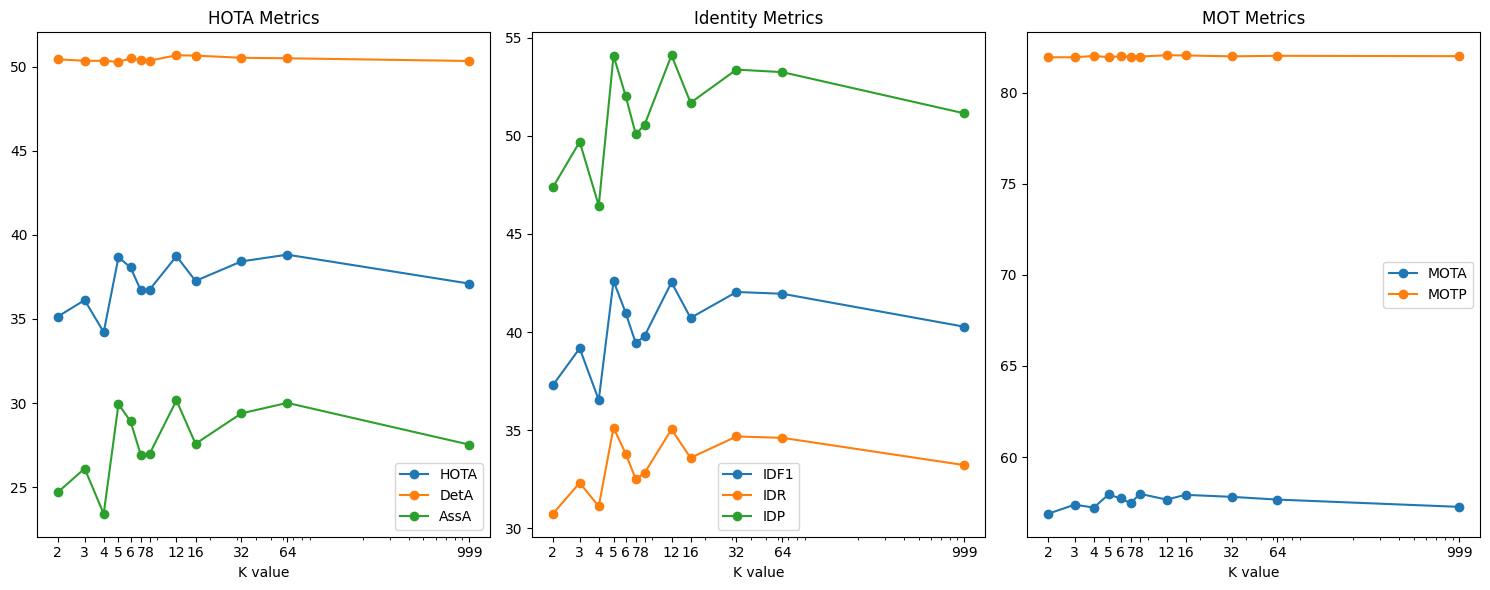

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个包含所有字典的列表
KFamily = {
    2: [35.14, 50.43, 24.70, 37.29, 30.74, 47.37, 56.89, 81.94],
    3: [36.12, 50.34, 26.11, 39.17, 32.32, 49.69, 57.39, 81.94],
    4: [34.21, 50.34, 23.42, 36.54, 31.12, 46.44, 57.23, 82.01],
    5: [38.67, 50.28, 29.94, 42.60, 35.13, 54.08, 57.95, 81.95],
    6: [38.06, 50.48, 28.91, 40.99, 33.81, 52.04, 57.73, 82.00],
    7: [36.70, 50.38, 26.92, 39.42, 32.50, 50.07, 57.47, 81.96],
    8: [36.74, 50.35, 26.98, 39.81, 32.83, 50.57, 57.99, 81.98],
    12: [38.73, 50.67, 30.16, 42.53, 35.04, 54.10, 57.67, 82.05],
    16: [37.26, 50.65, 27.58, 40.72, 33.59, 51.68, 57.93, 82.04],
    32: [38.42, 50.52, 29.39, 42.04, 34.68, 53.37, 57.82, 81.99],
    64: [38.82, 50.49, 30.01, 41.95, 34.61, 53.24, 57.67, 82.02],
    999: [37.10, 50.33, 27.53, 40.27, 33.22, 51.14, 57.27, 82.00],
}

# 创建一个包含所有指标的列表
metrics = ['HOTA', 'DetA', 'AssA', 'IDF1', 'IDR', 'IDP','MOTA','MOTP']

# 创建一个新的figure
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# 定义 x 的值（K 的值）并排序
x = sorted(KFamily.keys())

# 绘制每个指标的折线图
for i, metric in enumerate(metrics):
    if i < 3:
        idx = 0
        title = 'HOTA Metrics'
    elif 3 <= i < 6:
        idx = 1
        title = 'Identity Metrics'
    else:
        idx = 2
        title = 'MOT Metrics'
    # 提取对应的 y 值
    y = [KFamily[k][i] for k in x]

    # 绘制折线
    axs[idx].plot(x, y, marker='o', label=metric)
    axs[idx].set_title(title)
    axs[idx].set_xlabel('K value')
    # axs[idx].set_ylabel('Value')
    axs[idx].set_xscale('log')  # 设置为对数刻度

    # 设置对数刻度的刻度值
    axs[idx].set_xticks(x)
    axs[idx].get_xaxis().set_major_formatter(plt.ScalarFormatter())
    axs[idx].tick_params(axis='x', rotation=0)  # 旋转刻度标签方便显示

# 显示图例
for ax in axs.flat:
    ax.legend()

# 调整布局
plt.tight_layout()
plt.savefig('.assert/Kfamily_metrics.png')
# 显示图像
plt.show()


# 5.Mask

In [ ]:
import matplotlib.pyplot as plt
metrics = ['HOTA', 'DetA', 'AssA', 'IDF1', 'IDR', 'IDP','MOTA','MOTP']

table = {
    35: [43.33         , 50.84 , 37.11 , 51.01 , 42.11 , 64.70 , 59.46 , 81.99],
    50: [ 45.19, 50.51 ,40.61 , 52.12 , 43.04 , 66.07 , 59.05 , 81.98],
    60: [43.59    , 50.33 , 37.93 , 49.91 , 41.20 , 63.27 , 58.73 , 81.95],
    100: [39.72    , 50.34 , 31.53 , 43.74 , 36.11 , 55.45 , 57.71 , 81.92],
    150: [37.91    , 50.40 , 28.73 , 40.82 , 33.69 , 51.77 , 57.03 , 81.97],
    200: [36.47         , 50.33 , 26.61 , 39.49 , 32.58 , 50.10 , 56.69 , 81.95],
    250: [35.09         , 50.26 , 24.69 , 37.80 , 31.18 , 47.99 , 56.26 , 81.98],
    300: [34.69    ,50.42, 24.03 ,36.72 ,30.29 ,46.62 ,56.20 ,81.97],
    350: [29.33 , 49.58 , 17.47 , 30.08 , 24.72 , 38.42 , 53.06 , 81.91],
    400: [31.91   , 50.26 , 20.40 , 33.99 , 28.02 , 43.18 , 55.78 , 81.96],
    450: [32.70    ,50.33, 21.38 ,35.12 ,28.96 ,44.63 ,55.77 ,81.97],
    500: [32.58 ,50.27, 21.26, 35.16, 28.99, 44.66, 55.90, 81.96],
    "None": [25.29, 51.08, 12.57, 25.02, 20.49, 32.13, 50.01, 83.86],
}


# 创建一个新的figure
fig, axs = plt.subplots(3, 3, figsize=(15, 6))

# 绘制每个指标的折线图
for cnt in range(3):
    if cnt == 1:
        title = r'Distance Mask '

    for i, metric in enumerate(metrics):    
        if i < 3:
            idx = 0
            title = 'HOTA Metrics'
        elif 3 <= i < 6:
            idx = 1
            title = 'Identity Metrics'
        else:
            idx = 2
            title = 'MOT Metrics'
        # 提取对应的 y 值
        y = [KFamily[k][i] for k in x]

        # 绘制折线
        axs[cnt,idx].plot(x, y, marker='o', label=metric)
        axs[cnt,idx].set_title(title)
        axs[cnt,idx].set_xlabel('Mask Value')
        # axs[idx].set_ylabel('Value')
        axs[cnt,idx].set_xscale('log')  # 设置为对数刻度

        # 设置对数刻度的刻度值
        axs[cnt,idx].set_xticks(x)
        axs[cnt,idx].get_xaxis().set_major_formatter(plt.ScalarFormatter())
        axs[cnt,idx].tick_params(axis='x', rotation=0)  # 旋转刻度标签方便显示

# 显示图例
for ax in axs.flat:
    ax.legend()

# 调整布局
plt.tight_layout()
plt.savefig('.assert/Kfamily_metrics.png')
# 显示图像
plt.show()


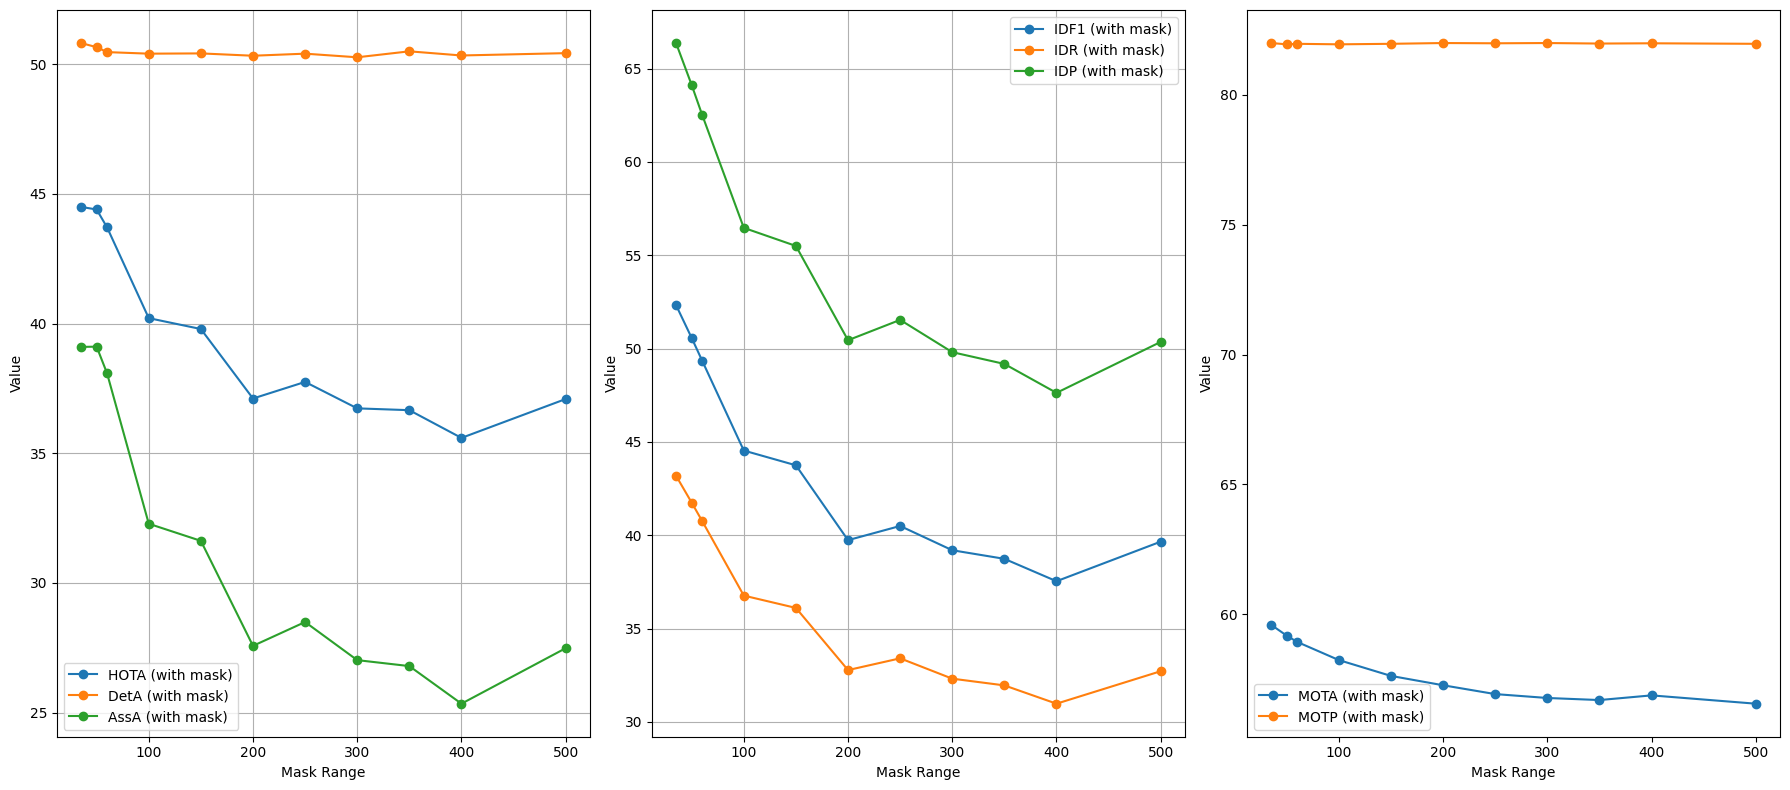

In [1]:
# Fixing the issue with x and y lengths and ensuring consistent plotting
import numpy as np
import matplotlib.pyplot as plt
metrics = ['HOTA', 'DetA', 'AssA', 'IDF1', 'IDR', 'IDP','MOTA','MOTP']

table = {
    35: [44.50, 50.82, 39.10, 52.33, 43.19, 66.37, 59.59, 82.00],
    50: [44.40, 50.66, 39.11, 50.57, 41.75, 64.12, 59.17, 81.95],
    60: [43.71, 50.47, 38.08, 49.36, 40.77, 62.53, 58.93, 81.97],
    100: [40.21, 50.41, 32.28, 44.54, 36.77, 56.47, 58.23, 81.95],
    150: [39.79, 50.42, 31.62, 43.75, 36.11, 55.50, 57.62, 81.97],
    200: [37.11, 50.33, 27.57, 39.74, 32.78, 50.45, 57.26, 82.00],
    250: [37.75, 50.41, 28.49, 40.50, 33.41, 51.54, 56.92, 81.99],
    300: [36.73, 50.27, 27.02, 39.20, 32.32, 49.81, 56.77, 82.00],
    350: [36.66, 50.50, 26.79, 38.74, 31.96, 49.18, 56.69, 81.98],
    400: [35.59, 50.34, 25.34, 37.54, 30.98, 47.63, 56.87, 81.99],
    500: [37.09, 50.43, 27.48, 39.66, 32.72, 50.36, 56.55, 81.97],
    "None": [35.14, 50.43, 24.70, 37.29, 30.74, 47.37, 56.89, 81.94],
}

# Clean x to only include integers
x = [key for key in table.keys() if isinstance(key, int)]

# Function to plot a single table
def plot_table(axs, table, title, row):
    for i, metric in enumerate(metrics):
        y = [table[k][i] for k in table if isinstance(k, int)]  # Filter out non-integer keys
        ax = axs[row, i // 3]  # Determine subplot based on metric index
        ax.plot(x, y, marker='o', label=metric)  # Use cleaned x
        ax.set_title(title if i % 3 == 0 else "")  # Set title only for the first metric in the row
        ax.set_xlabel('Mask Range')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid()

# Function to compare two tables
def plot_comparison(axs, table1, table2, title, row):
    for i, metric in enumerate(metrics):
        y1 = [table1[k][i] for k in table1 if isinstance(k, int)]
        # y2 = [table2[k][i] for k in table2 if isinstance(k, int)]
        ax = axs[ i // 3]
        ax.plot(x, y1, marker='o', label=f"{metric} (with mask)", linestyle='-')
        # ax.plot(x, y2, marker='s', label=f"{metric} (without mask)", linestyle='-')
        ax.set_title(title if i % 3 == 0 else "")
        ax.set_xlabel('Mask Range')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid()

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 8))

# First row: Table 1
# plot_table(axs, table, "Table 1 Metrics (Trained with Distance Mask)", 0)

# # Second row: Table 2
# plot_table(axs, table_2, "Table 2 Metrics (Trained without Distance Mask)", 1)

# Third row: Comparison
plot_comparison(axs, table, None, "Comparison Between Table 1 and Table 2", 0)

# Adjust layout
plt.tight_layout()
plt.savefig('.assert/mask.png')
plt.show()


# 伪造只有一个物体的图，看看图卷积输出

In [ ]:
#---------------------------------#
#  num_nodes 为1 的特殊情况 只在检测器中检测到
#---------------------------------#
import cv2
path = r'datasets\eval_datasets\gt\mot_challenge\MOT17-half\MOT17-13\img1\000093.jpg'
bbox = (99, 571, 81, 179) # SDP
img = cv2.imread(path)
cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 8)

# 显示图片
cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite(r'experiments\single(93-MOT17-13).png',img)

In [5]:
import torchvision.io.image as I
from torch_geometric.data import Data
import torchvision.transforms.functional as T


path = r'datasets\eval_datasets\gt\mot_challenge\MOT17-half\MOT17-13\img1\000093.jpg'
bbox = (99, 571, 81, 179) # SDP

im_tensor = I.read_image(path)
img_tensor  = im_tensor.to(torch.float32) / 255.0
raw_node_attr , location_info = [] , []
im_tensor = T.normalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

x , y , w , h = map(int, bbox)
xc , yc   = x + w/2 , y + h/2
x2 , y2   = x + w   , y + h
if x < 0:
    w = w + x  
    x = 0 

if y < 0:
    h = h + y  
    y = 0  
    
w = min(w, im_tensor.shape[2] - x)  
h = min(h, im_tensor.shape[1] - y)

patch = T.crop(im_tensor,y,x,h,w)
patch = T.resize(patch,[256,128])
raw_node_attr.append(patch)
location_info.append([x,y,x2,y2,w,h,xc,yc])

raw_node_attr = torch.stack(raw_node_attr,dim=0)
location_info = torch.as_tensor(location_info,dtype=torch.float32)
sigle_graph = Data(x=raw_node_attr,location_info=location_info)

In [ ]:
#---------------------------------#
# 加载模型
#---------------------------------#

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#---------------------------------#
#  load  configs and checkpoint 
#---------------------------------#
import torch
from configs.config import get_config
from models.graphModel import GraphModel
from utils.graphDataset import GraphDataset
cfg = get_config()

model = GraphModel(cfg.MODEL_YAML_PATH)
checkpoint = torch.load(r'model_weights\DA_120epoch.pth',map_location='cpu')
model.load_state_dict(checkpoint["model"], strict=False)
model.eval()

In [ ]:
#---------------------------------#
#  Node Encoder 
#---------------------------------#
sigle_graph_model =  model.nodeEncoder(sigle_graph.clone())
sigle_graph, sigle_graph_model

In [ ]:
#---------------------------------#
# Edge Encoder
#---------------------------------#
sigle_graph_model = model.edgeEncoder(sigle_graph_model,model.k)
sigle_graph_model

In [ ]:
sigle_graph_model.edge_index,sigle_graph_model.edge_attr

# 7. 计算FLOPS

In [1]:
#---------------------------------#
#  载入数据
#---------------------------------#

#---------------------------------#
#  预备工作：
#  导入库
#  加载配置文件
#  加载模型，加载数据集
#---------------------------------#

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#---------------------------------#
#  load  configs and checkpoint 
#---------------------------------#
import torch
from configs.config import get_config
from models.graphModel import GraphModel
from utils.graphDataset import GraphDataset
cfg = get_config()

cfg.JSON_PATH = r'configs\train_MOT17.json'
test_dataset = GraphDataset(cfg,'Validation',False)

d:\anaconda3\envs\2torch1.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[Validation] Data-preprocess: 100%|██████████| 1/1 [00:00<00:00,  2.07dataset/s]
2025-01-06 21:53:53.126 | INFO     | utils.graphDataset:__init__:96 - [Validation] Total frame number : 2652


In [2]:
tra_graph , det_graph , _= test_dataset.__getitem__(2120)

In [3]:
import torch
from fvcore.nn import FlopCountAnalysis, flop_count_table
from models.graphModel import TrainingGraphModel, GraphModel

# Example of loading your model
# model_yaml_path = 'path_to_your_model_yaml.yaml'  # Update this path
model = GraphModel(cfg.MODEL_YAML_PATH)  # You can switch to GraphModel if required

# Dummy inputs for the model
from torch_geometric.data import Batch, Data

# checkpoint = torch.load(r'model_weights\DA_120epoch.pth',map_location='cpu')
# model.load_state_dict(checkpoint["model"], strict=False)
# Create example input data compatible with your model
# Make sure to adjust these inputs based on your actual graph data
model.eval()
# Convert Data objects to tuples of tensors
def graph_to_tuple(graph):
    return (graph.x, graph.edge_index,graph.location_info)

tra_tuple = graph_to_tuple(tra_graph)
det_tuple = graph_to_tuple(det_graph)

# Custom wrapper to adapt the forward pass of the model
class FLOPSWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, tra_tuple, det_tuple):
        # Reconstruct Data objects from tuples for forward pass
        tra_graph = Data(x=tra_tuple[0], edge_index=tra_tuple[1],location_info=tra_tuple[2])
        det_graph = Data(x=det_tuple[0], edge_index=det_tuple[1],location_info=det_tuple[2])
        return self.model(tra_graph, det_graph)
# Wrap the model
wrapped_model = FLOPSWrapper(model)

# Calculate FLOPS
try:
    flops = FlopCountAnalysis(wrapped_model, (tra_tuple, det_tuple))
    print(flop_count_table(flops))
except Exception as e:
    print(f"Error calculating FLOPS: {e}")



| module                                       | #parameters or shape   | #flops     |
|:---------------------------------------------|:-----------------------|:-----------|
| model                                        | 9.851M                 | 29.98G     |
|  alpha                                       |  (1,)                  |            |
|  eplison                                     |  (1,)                  |            |
|  nodeEncoder                                 |  7.654M                |  29.943G   |
|   nodeEncoder.backbone.0                     |   6.954M               |   29.931G  |
|    nodeEncoder.backbone.0.conv0              |    9.408K              |    1.233G  |
|    nodeEncoder.backbone.0.norm0              |    0.128K              |    16.777M |
|    nodeEncoder.backbone.0.denseblock1        |    0.335M              |    10.979G |
|    nodeEncoder.backbone.0.transition1        |    33.28K              |    1.091G  |
|    nodeEncoder.backbone.0.denseblock2    

In [ ]:
import matplotlib.pyplot as plt
colors = [ '#99ff99', '#ffcc99', '#c2c2f0']
# Define the new components and their corresponding FLOPS (GigaFLOPS)
components = [
    "node Encoder",
    # "edge Encoder",
    "SDGCN",
    # "Dynamic GCN",
    "Fuse Model"
]
flops_new = [
    29.943,        # FLOPS for nodeEncoder (in GFLOPS)
    # 0.0192,        # FLOPS for edgeEncoder (in GFLOPS)
    # 0.001716,      # FLOPS for sgconv (sum of sg1conv, sg2conv, sg3conv)
    3.306,         # FLOPS for dgconv (sum of dg1conv and dg2conv)
    33.23          # FLOPS for fuse (sum of fuse1conv and fuse2conv)
]

# Plotting the updated pie chart with 5 components
plt.figure(figsize=(8, 8))
plt.pie(flops_new, labels=components, autopct='%1.1f%%', startangle=140,colors=colors,wedgeprops={'edgecolor': 'black'},textprops={'fontsize': 18}, )
plt.title("FLOPS Distribution Across Model Components", fontsize=20, fontweight='bold')
plt.savefig('.assert/FLOPS(VanillaModel).png')
plt.show()


In [ ]:
# Define the components and their corresponding parameter counts (in millions)
components_params = [
    "node Encoder",
    "SDGCN",
    "Fuse Model"
]
params_new = [
    7.654,  # Parameters for nodeEncoder (in millions)
    2.236,  # Parameters for SDGCN (graphconvLayer)
    2.077   # Parameters for Fuse Model (sum of fuse1conv and fuse2conv)
]

# Colors for the chart
colors_params_blue = ['#66b3ff', '#3399ff', '#99ccff']
colors_params = ['#ff9999', '#99ff99', '#ffcc99']
# Plotting the parameter distribution pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    params_new,
    labels=components_params,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors_params,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 18}
)
plt.title("Parameter Distribution Across Model Components", fontsize=20, fontweight='bold')
plt.savefig('.assert/Parms(VanillaModel).png')
plt.show()


In [9]:
import cv2
import os
import imageio

# 标注数据
annotations = [
    {'frame_number': 426, 'bbox': (1800, 353, 501, 993)},
    {'frame_number': 427, 'bbox': (1747, 348, 499, 997)},
    {'frame_number': 428, 'bbox': (1694, 344, 498, 1000)},
    {'frame_number': 429, 'bbox': (1641, 340, 497, 1003)},
    {'frame_number': 430, 'bbox': (1588, 336, 496, 1006)},
    {'frame_number': 431, 'bbox': (1535, 332, 495, 1009)},
    {'frame_number': 432, 'bbox': (1482, 327, 493, 1013)},
    {'frame_number': 433, 'bbox': (1429, 323, 492, 1016)},
    {'frame_number': 434, 'bbox': (1376, 319, 491, 1019)},
    {'frame_number': 435, 'bbox': (1323, 315, 490, 1022)},
    {'frame_number': 436, 'bbox': (1270, 311, 489, 1026)},
    {'frame_number': 437, 'bbox': (1221, 324, 469, 1015)},
    {'frame_number': 438, 'bbox': (1173, 338, 448, 1004)},
    {'frame_number': 439, 'bbox': (1124, 351, 428, 994)},
    {'frame_number': 440, 'bbox': (1076, 365, 408, 983)},
    {'frame_number': 441, 'bbox': (1029, 362, 403, 983)},
    {'frame_number': 442, 'bbox': (983, 359, 398, 983)},
    {'frame_number': 443, 'bbox': (936, 357, 394, 982)},
    {'frame_number': 444, 'bbox': (890, 354, 389, 982)},
    {'frame_number': 445, 'bbox': (844, 352, 384, 982)},
    {'frame_number': 446, 'bbox': (806, 348, 384, 982)},
    {'frame_number': 447, 'bbox': (768, 344, 384, 982)},
    {'frame_number': 448, 'bbox': (730, 340, 384, 982)},
    {'frame_number': 449, 'bbox': (693, 337, 383, 982)},
    {'frame_number': 450, 'bbox': (660, 344, 384, 981)},
    {'frame_number': 451, 'bbox': (628, 352, 384, 979)},
    {'frame_number': 452, 'bbox': (596, 359, 384, 979)},
    {'frame_number': 453, 'bbox': (564, 367, 384, 977)},
    {'frame_number': 454, 'bbox': (532, 375, 384, 976)},
    {'frame_number': 455, 'bbox': (493, 378, 384, 973)},
    {'frame_number': 456, 'bbox': (454, 381, 384, 970)},
    {'frame_number': 457, 'bbox': (415, 384, 384, 967)},
    {'frame_number': 458, 'bbox': (377, 387, 384, 964)},
    {'frame_number': 459, 'bbox': (347, 382, 384, 964)},
    {'frame_number': 460, 'bbox': (317, 378, 384, 964)},
    {'frame_number': 461, 'bbox': (287, 374, 384, 963)},
    {'frame_number': 462, 'bbox': (257, 370, 384, 963)},
    {'frame_number': 463, 'bbox': (228, 366, 383, 963)},
    {'frame_number': 464, 'bbox': (196, 367, 390, 963)},
    {'frame_number': 465, 'bbox': (165, 368, 396, 963)},
    {'frame_number': 466, 'bbox': (133, 369, 403, 963)},
    {'frame_number': 467, 'bbox': (102, 370, 409, 963)},
    {'frame_number': 468, 'bbox': (71, 372, 416, 962)},
    {'frame_number': 469, 'bbox': (45, 377, 416, 960)},
    {'frame_number': 470, 'bbox': (19, 382, 416, 958)},
    {'frame_number': 471, 'bbox': (-7, 387, 416, 956)},
    {'frame_number': 472, 'bbox': (-33, 392, 416, 954)},
    {'frame_number': 473, 'bbox': (-58, 398, 416, 952)},
    {'frame_number': 474, 'bbox': (-78, 395, 417, 952)},
    {'frame_number': 475, 'bbox': (-97, 392, 417, 953)},
    {'frame_number': 476, 'bbox': (-116, 390, 417, 952)},
    {'frame_number': 477, 'bbox': (-135, 387, 417, 953)},
    {'frame_number': 478, 'bbox': (-154, 384, 417, 953)},
    {'frame_number': 479, 'bbox': (-173, 382, 417, 953)},
    {'frame_number': 480, 'bbox': (-196, 382, 417, 952)},
    {'frame_number': 481, 'bbox': (-218, 382, 416, 952)},
    {'frame_number': 482, 'bbox': (-241, 382, 417, 952)},
    {'frame_number': 483, 'bbox': (-263, 382, 416, 952)},
    {'frame_number': 484, 'bbox': (-286, 382, 417, 952)},
    {'frame_number': 485, 'bbox': (-308, 382, 416, 952)},
    {'frame_number': 486, 'bbox': (-331, 382, 417, 952)},
    {'frame_number': 487, 'bbox': (-353, 382, 416, 952)},
]

# 图片文件夹路径
image_folder_path = 'datasets/MOT17/train/MOT17-02/img1'
frames = []
# 遍历每一帧的标注
for annotation in annotations:
    # 提取帧数和边界框坐标
    frame_number = annotation['frame_number']
    bbox = annotation['bbox']
    
    # 构建图片文件名
    image_file_name = f'{frame_number:06d}.jpg'
    image_file_path = os.path.join(image_folder_path, image_file_name)
    
    # 读取图片
    image = cv2.imread(image_file_path)
    text = f'id[{16}]-avg_Movement[{72.3}]pix'
    cv2.putText(image, text, (int(1920/2-100), 100), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
       
    # 绘制边界框
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 0, 255), 2)
    
    # 将图片转换为 RGB 格式，因为 imageio 需要 RGB 格式的图片
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 将图片添加到 frames 列表中
    frames.append(image)

# 保存为 GIF 动画
imageio.mimsave('output.gif', frames, duration=0.1)


In [ ]:
,80,1044,445,31,97,1,1,0
,80,1043,445,32,97,1,1,0
,80,1043,445,32,97,1,1,0
594,80,1043,445,32,97,1,1,0

In [11]:
import cv2
import os
import imageio

# 标注数据
annotations = [
    {'frame_number': 591, 'bbox': (1044,445,31,97)},
    {'frame_number': 592, 'bbox': (1043,445,32,97)},
    {'frame_number': 593, 'bbox': (1043,445,32,97)},
    {'frame_number': 594, 'bbox': (1043,445,32,97)},
]

# 图片文件夹路径
image_folder_path = 'datasets/MOT17/train/MOT17-02/img1'
frames = []
# 遍历每一帧的标注
for annotation in annotations:
    # 提取帧数和边界框坐标
    frame_number = annotation['frame_number']
    bbox = annotation['bbox']
    
    # 构建图片文件名
    image_file_name = f'{frame_number:06d}.jpg'
    image_file_path = os.path.join(image_folder_path, image_file_name)
    
    # 读取图片
    image = cv2.imread(image_file_path)
    text = f'id[{80}]-avg_Movement[{0.5}]pix'
    cv2.putText(image, text, (int(1920/2-100), 100), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
       
    # 绘制边界框
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 2)
    
    # 将图片转换为 RGB 格式，因为 imageio 需要 RGB 格式的图片
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 将图片添加到 frames 列表中
    frames.append(image)

# 保存为 GIF 动画
imageio.mimsave('output_2.gif', frames, duration=0.1)
